# `Библиотеки`

In [30]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

import matplotlib.pyplot as plt

# `Данные: загрузка и препроцессинг`

In [2]:
df = pd.read_csv("network_traffic.csv")

df

,time,source_ip_int,destination_ip_int,source_port,destination_port,protocol,duration,packet_count,bytes_sent,bytes_received,label,bytes_per_packet
0,2025-04-07 03:25:53,3232281727,167792955,32237,995,0,2.910802,74,9200,4879,0,124.324324
1,2025-04-07 08:38:03,3232236596,167774143,15995,995,0,4.661168,33,4015,1848,0,121.666667
2,2025-04-07 04:37:03,3232276946,167832337,65426,80,0,1.802558,23,2572,3190,0,111.826087
3,2025-04-07 01:30:53,3232270434,167796473,16433,993,0,4.126773,92,2993,3000,0,32.532609
4,2025-04-06 20:58:03,3232267105,167776023,27110,143,2,1.949097,43,4257,6826,0,99.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
10000,2025-04-06 20:40:18,3232250619,167783555,59711,64660,5,9.643456,78,17193,11333,1,220.423077
10001,2025-04-07 05:20:03,3232295215,167799884,26804,995,1,1.425016,91,240,981,0,2.637363
10002,2025-04-07 05:24:53,3232292523,167822026,63303,23,1,2.121701,43,4877,7670,0,113.418605
10003,2025-04-07 17:11:53,3232252147,167774716,31382,993,1,1.787258,28,6632,366,0,236.857143


In [3]:
print("Пропущенные значения:")
display(df.isna().sum().sort_values(ascending=False).head(20))

Пропущенные значения:


,0
time,0
source_ip_int,0
destination_ip_int,0
source_port,0
destination_port,0
protocol,0
duration,0
packet_count,0
bytes_sent,0
bytes_received,0


In [4]:
print("Распределение количества обычного и аномального трафика:")
df["label"].value_counts(normalize=True) * 100

Распределение количества обычного и аномального трафика:


,proportion
label,
0,79.96002
1,20.03998


In [5]:
print("Дубликаты строк:", df.duplicated().sum())

Дубликаты строк: 0


In [6]:
df = df.copy()

df["time"] = pd.to_datetime(df["time"], errors="coerce")

df["hour"] = df["time"].dt.hour.astype("Int64")
df["dayofweek"] = df["time"].dt.dayofweek.astype("Int64")
df["time_unix"] = (df["time"].astype("int64") // 10**9).astype("Int64")

if "bytes_per_packet" not in df.columns:
    df["bytes_per_packet"] = df["bytes_sent"] / df["packet_count"].replace(0, np.nan)

df["bytes_total"] = df["bytes_sent"] + df["bytes_received"]
df["bytes_sent_ratio"] = df["bytes_sent"] / df["bytes_total"].replace(0, np.nan)

df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["label"])

df

,time,source_ip_int,destination_ip_int,source_port,destination_port,protocol,duration,packet_count,bytes_sent,bytes_received,label,bytes_per_packet,hour,dayofweek,time_unix,bytes_total,bytes_sent_ratio
0,2025-04-07 03:25:53,3232281727,167792955,32237,995,0,2.910802,74,9200,4879,0,124.324324,3,0,1743996353,14079,0.653456
1,2025-04-07 08:38:03,3232236596,167774143,15995,995,0,4.661168,33,4015,1848,0,121.666667,8,0,1744015083,5863,0.684803
2,2025-04-07 04:37:03,3232276946,167832337,65426,80,0,1.802558,23,2572,3190,0,111.826087,4,0,1744000623,5762,0.446373
3,2025-04-07 01:30:53,3232270434,167796473,16433,993,0,4.126773,92,2993,3000,0,32.532609,1,0,1743989453,5993,0.499416
4,2025-04-06 20:58:03,3232267105,167776023,27110,143,2,1.949097,43,4257,6826,0,99.000000,20,6,1743973083,11083,0.384102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10000,2025-04-06 20:40:18,3232250619,167783555,59711,64660,5,9.643456,78,17193,11333,1,220.423077,20,6,1743972018,28526,0.602713
10001,2025-04-07 05:20:03,3232295215,167799884,26804,995,1,1.425016,91,240,981,0,2.637363,5,0,1744003203,1221,0.196560
10002,2025-04-07 05:24:53,3232292523,167822026,63303,23,1,2.121701,43,4877,7670,0,113.418605,5,0,1744003493,12547,0.388698
10003,2025-04-07 17:11:53,3232252147,167774716,31382,993,1,1.787258,28,6632,366,0,236.857143,17,0,1744045913,6998,0.947699


## `Выбор фичей`

In [8]:
target = "label"

drop_cols = ["time", target]
drop_cols = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=drop_cols).copy()
y = df[target].astype(int).values

X = X.apply(pd.to_numeric, errors="coerce")
X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

for c in ["source_ip_int", "destination_ip_int"]:
    if c in X.columns:
        X = X.drop(columns=[c])

X_values = X.values.astype(np.float32)

# `Разделение на train/test и обучение`

In [9]:
X_train_all, X_test, y_train_all, y_test = train_test_split(
    X_values, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train_norm = X_train_all[y_train_all == 0]
print("train_all:", X_train_all.shape, "train_norm:", X_train_norm.shape, "test:", X_test.shape)

train_all: (8004, 13) train_norm: (6400, 13) test: (2001, 13)


In [10]:
class NpOnlyDataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]
        return x, x

train_ds = NpOnlyDataset(X_train_norm)
test_ds  = NpOnlyDataset(X_test)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=512, shuffle=False, num_workers=0)

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_in, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, n_in),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(n_in=X_train_norm.shape[1]).to(device)
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=13, bias=True)
  )
)

In [13]:
criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

history = []

for epoch in range(1, 256):
    model.train()
    losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        x_hat = model(xb)
        loss = criterion(x_hat, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = float(np.mean(losses))
    history.append((epoch, mean_loss))
    if epoch % 10 == 0 or epoch == 1:
        print(f"epoch={epoch:02d} recon_mse={mean_loss:.6f}")

epoch=01 recon_mse=51918809374.720001
epoch=10 recon_mse=32734402.880000
epoch=20 recon_mse=33070572.880000
epoch=30 recon_mse=37075688.400000
epoch=40 recon_mse=36212755.360000
epoch=50 recon_mse=35647114.160000
epoch=60 recon_mse=68937537.600000
epoch=70 recon_mse=43580478.960000
epoch=80 recon_mse=38216606.320000
epoch=90 recon_mse=34520192.960000
epoch=100 recon_mse=41273361.280000
epoch=110 recon_mse=130103743.520000
epoch=120 recon_mse=57035388.800000
epoch=130 recon_mse=51945379.680000
epoch=140 recon_mse=37524065.440000
epoch=150 recon_mse=45951134.080000
epoch=160 recon_mse=44435779.680000
epoch=170 recon_mse=49441474.560000
epoch=180 recon_mse=86431112.640000
epoch=190 recon_mse=75006244.160000
epoch=200 recon_mse=85356452.320000
epoch=210 recon_mse=51583377.440000
epoch=220 recon_mse=41938453.120000
epoch=230 recon_mse=47022622.080000
epoch=240 recon_mse=110047264.480000
epoch=250 recon_mse=53745915.360000


In [14]:
def reconstruction_error(model, loader):
    model.eval()
    errs = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            x_hat = model(xb)
            # MSE по объекту
            e = ((x_hat - yb) ** 2).mean(dim=1)
            errs.append(e.cpu().numpy())
    return np.concatenate(errs)

test_err = reconstruction_error(model, test_loader)

test_err

array([4.0963651e+08, 7.6315072e+07, 9.4495320e+06, ..., 2.5685182e+07,
       2.4902446e+07, 1.4326878e+07], dtype=float32)

# `Качество классификации`

In [16]:
roc = roc_auc_score(y_test, test_err)
print(f"ROC-AUC: {roc:.4f}")

ROC-AUC: 0.9197


In [18]:
train_loader_eval = DataLoader(train_ds, batch_size=512, shuffle=False, num_workers=0)
train_err = reconstruction_error(model, train_loader_eval)

thr = np.quantile(train_err, 0.95)
print("threshold (q=0.95):", thr)

pred = (test_err >= thr).astype(int)

print("\nClassification report:")
print(classification_report(y_test, pred, digits=4))

threshold (q=0.95): 94856580.0

Classification report:
              precision    recall  f1-score   support

           0     0.9363    0.9469    0.9416      1600
           1     0.7781    0.7431    0.7602       401

    accuracy                         0.9060      2001
   macro avg     0.8572    0.8450    0.8509      2001
weighted avg     0.9046    0.9060    0.9052      2001



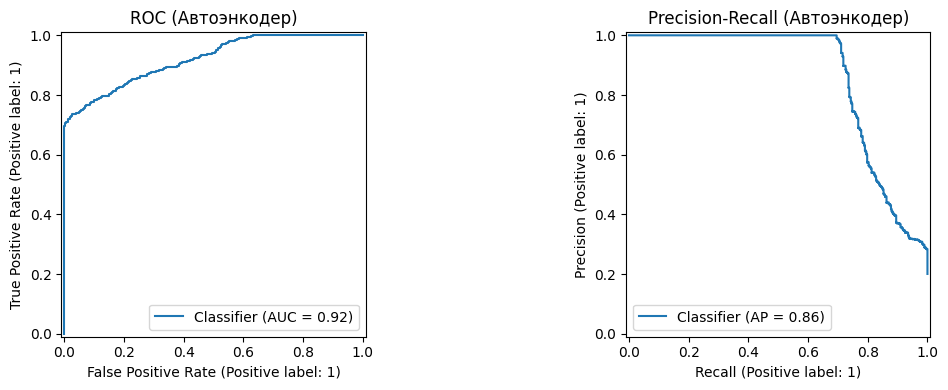

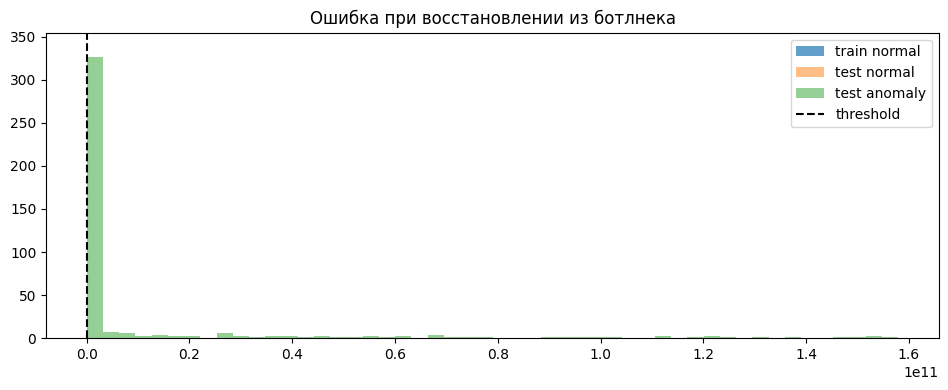

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
RocCurveDisplay.from_predictions(y_test, test_err, ax=ax[0])
PrecisionRecallDisplay.from_predictions(y_test, test_err, ax=ax[1])
ax[0].set_title("ROC (Автоэнкодер)")
ax[1].set_title("Precision-Recall (Автоэнкодер)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9.59, 4))
plt.hist(train_err, bins=50, alpha=0.7, label="train normal")
plt.hist(test_err[y_test == 0], bins=50, alpha=0.5, label="test normal")
plt.hist(test_err[y_test == 1], bins=50, alpha=0.5, label="test anomaly")
plt.axvline(thr, color="black", linestyle="--", label="threshold")
plt.legend()
plt.title("Ошибка при восстановлении из ботлнека")
plt.tight_layout()
plt.show()